# I. Getting Started with Pitching Tents

**[Jay Gopalakrishnan](https://web.pdx.edu/~gjay/)**  (gjay@pdx.edu)

**July 2023 NGSolve User Meeting Lecture: Part I**

<br>
<hr>

Tent-shaped spacetime regions are natural for solving hyperbolic problems.
Due to their finite propagation speed, hyperbolic solutions have a cone-shaped domain of dependence at each point. The slope of the cone depends on the wave speed. Such cones of domain of dependence are shown shaded in the figures below.

<img src="figs/CausalityCond.png">

The left figure above has a tent (drawn in black edges). Every point in this tent has a domain of dependence that is contained within the tent. Such a tent is said to satisfy the **causality condition**. The right figure shows a tent whose tentpole is too high to satisfy the causality condition. The domain of dependence of some points in the tent falls outside of the tent.  Note that the causality condition depends only on the exact hyperbolic wave speed,  is independent of the discretization, and is not the same as a CFL condition.

The `ngstents` package provides facilities to mesh a spacetime region with tents satisfying the causality condition. Such meshes can be thought of as  made up of advancing fronts (advancing in time) and naturally allow locally variable time stepping on  unstructured spatial meshes. The package also provides implementations of some hyperbolic solvers within tents.

We start by importing `TentSlab`, a class which knows how to subdivide spacetime slabs into tents.

In [2]:
import ngsolve as ng
from ngstents import TentSlab

## Tents atop one space dimension

It is easiest to illustrate tent meshes in one space dimension plus time (where the meshes will appear as 2D meshes). The implementation of tent meshing algorithm is based on a [[2017 paper]](https://doi.org/10.1137/16M1101374) which gives a uniform algorithmic strategy in any dimension.

In [3]:
from ngsolve.meshes import Make1DMesh
mesh = Make1DMesh(4)
ts = TentSlab(mesh)

The `ts` object represents a spacetime slab atop the spatial `mesh`. 
The  **time height** `dt` of the spacetime slab must be set before 
it can be filled with tents. 

In [4]:
dt = 0.3  # Time-height of spacetime slab to be meshed with tents

Also, in order to satisfy the causality condition, the algorithm needs an **estimate of the maximal wave speed**.

In [5]:
c = 3     # An estimate of maximal wave speed
ts.SetMaxWavespeed(c)

Now, we are ready to pitch tents and fill the spacetime slab with tents.  As usual, all documentation in docstrings are accessible using python's help system, for example, by typing `help(ts.PitchTents)`.

In [6]:
ts.PitchTents(dt);

A simple matplotlib-based visualization is provided for the one-dimensional case. Using it, we see the mesh of tents just made in a two-dimensional diagram where the vertical axis represents time. 

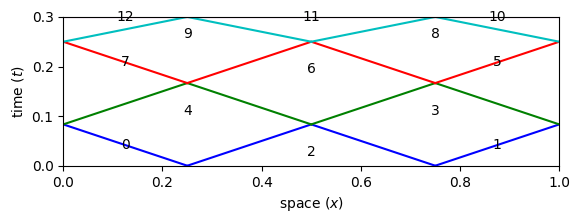

In [7]:
ts.DrawPitchedTentsPlt(showtentnums=True)

This visualizes the spacetime slab, of the height `dt` that we specified, subdivided into tents. The colors above represent **advancing fronts** and indicate a **tent level number**. Beginning with a flat advancing front ($t=0$), the next front (the blue front above) is made of canopies of all level 1 tents. Level 2 tents are pitched atop of level 1 tents and produce the bext advancing front (shown in green above), and so on.

When solving hyperbolic systems, **all tents in the same level are processed in parallel** using thread parallelism facilities (thanks to ngsolve's TaskManager). Level 2 tents can be solved only after Level 1 tents are solved, and so on. Hence  a *directed acyclic graph* (DAG) of tent dependencies, like that shown below,  is created internally in `ngstents` and used in a concurrent queue for task parallel implementation. 

<center><img src="./figs/dag.png" width="40%"></center>

Some properties of the C++ class representing `TentSlab` are exposed in python. You can query tent and spacetime slab properties using the available python attributes.

In [8]:
print('Number of tents:',   ts.GetNTents()) # Query TentSlab
print('Maximal tent slope:', ts.MaxSlope())

Number of tents: 13
Maximal tent slope: 0.33333333333333326


In [9]:
n = 6  # Query a tent of number n
t = ts.GetTent(n)
print('Details of Tent #%d:' % n)
print('  Pitching (central) vertex number:', t.vertex)
print('  Neighbor vertex numbers:', list(t.nbv))
print('  Tent element numbers:',    list(t.els))
print('  Neighbor vertex heights:', list(t.nbtime))

Details of Tent #6:
  Pitching (central) vertex number: 2
  Neighbor vertex numbers: [1, 3]
  Tent element numbers: [1, 2]
  Neighbor vertex heights: [0.1666666666666666, 0.1666666666666666]


<br>

As you may expect, the tent mesh will get more complex if the spatial mesh is complex. Indeed, the main interest in using tents is for seamlessly enabling **variable time advance** (aka, local time stepping) on nonuniform spatial meshes. Here is a simple example that illustrates this using a nonuniform spatial mesh, staying in one space dimension. 

In [10]:
mesh = Make1DMesh(7, mapping=lambda x: 1-x**2)
for v in mesh.vertices: print(v.point)

(1.0,)
(0.9795918367346939,)
(0.9183673469387755,)
(0.8163265306122449,)
(0.6734693877551021,)
(0.4897959183673469,)
(0.26530612244897966,)
(0.0,)


Spatial mesh points are now more packed near 1 compared to 0. In order to satisfy the causality condition, smaller spatial elements will necessitate smaller tents to be built atop them.

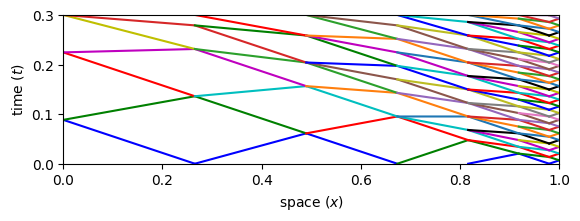

In [11]:
ts = TentSlab(mesh)
ts.SetMaxWavespeed(c)
ts.PitchTents(dt)
ts.DrawPitchedTentsPlt()

Near the right boundary, we see how smaller time steps are automatically realized. The algorithm has determined that larger time advances can be made in regions of larger spatial elements without violating causality.

Another scenario of interest is when the hyperbolic wavespeed varies significantly from one part of the domain to another. To handle such cases, the maximal wavespeed input `c` can be a spatially varying coefficient function, as in the next example.

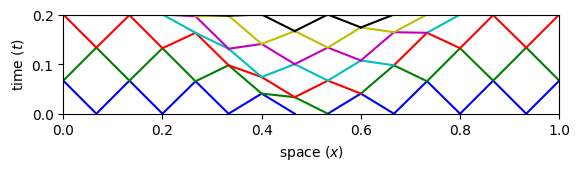

In [12]:
mesh = Make1DMesh(15)
dt=0.2
ts = TentSlab(mesh)

# set c to higher wavespeed in the middle of the domain:
ts.SetMaxWavespeed(1 + ng.CF(ng.exp(-100 * (ng.x-0.5)**2)))  

ts.PitchTents(dt)
ts.DrawPitchedTentsPlt()

Clearly, the resulting tents have smaller tent poles near the middle of the domain. 

## An acoustic wave in two space dimensions

Next, we turn to two space dimensions and solve the wave equation using tents. The submodule `ngstent.conslaw` has methods for solving first order hyperbolic conservation laws.

In standard second order form, the scalar wave equation reads 
$$
\def\d{\partial}
\newcommand{\divx}{\text{div}_{\vec{x}}}
\newcommand{\gradx}{\text{grad}_{\vec{x}}}
\begin{aligned}
      \d_{tt} \phi 
      % = \beta \d_t \phi
      - \Delta  \phi
      & = 0 
\end{aligned}
$$
for a scalar function $\phi$. To use the facilities in this package, we first reformulate it as a first order hyperbolic system using the state variable 
$$
      u =
      \begin{bmatrix}
        q \\ \mu 
      \end{bmatrix}
      = 
      \begin{bmatrix}
        -\gradx \phi 
        \\ 
        \d_t \phi
      \end{bmatrix}. 
$$
Here $q$ is the vector flux of the scalar wave $\phi$, and the state variable $u$ is the 3-component vector function that we need to find.  From the second order equation for $\phi$, we easily obtain the system 
$$
    \begin{aligned}
    \underbrace{
      \frac{\d}{\d t}% \d_t 
            \begin{bmatrix}
              q \\ \mu 
            \end{bmatrix}
      }_{\textstyle{\d_t u}}
      +
      \underbrace{
      \begin{bmatrix}
        0 & \gradx \\
       \divx & 0 
      \end{bmatrix}
            \begin{bmatrix}
              q \\ \mu 
            \end{bmatrix}
      }_{\divx
      {\textstyle{
      \underbrace{\textstyle{
      \left[
      \begin{smallmatrix}
        I \mu \\ q
      \end{smallmatrix}
      \right]
      }
      }_{\textstyle{f(u)}}}}}    = 0    
\end{aligned}
$$
which is a first order conservation law in its familiar form 
$$
\d_t u + \divx f(u) =0
$$
with the above-indicated flux $f$.

The two-dimensional spatial variable $\vec{x} = (x, y)$ lies in a spatial domain, which in the problem we proceed to solve, is composed of a small pipe and a large opening.  We start with an intial scalar wave profile of the form $\phi(\vec{x}, 0) = e^{-d\, (y+\text{shift})^2}$, choosing shift and $d$ so that the wave is almost confined in the small pipe at start. The corresponding initial $u_0$ is set and drawn below, after constructing the geometry and mesh.

In [13]:
from netgen.geom2d import EdgeInfo as EI, Solid2d, CSG2d
from ngsolve.webgui import Draw
from ngsolve import L2, GridFunction, x, y, exp, CF

geo = CSG2d()
horn = Solid2d(
    [(1, 0.55),
     EI((1, 1), bc='out'),      # right curved boundary (with control point)
     (0, 1),
     EI((-1,  1), bc='out'),    # left curved bdry
     (-1, 0.55),
     EI(bc='cone'),             # conical walls
     (-0.03, 0),
     EI(maxh=0.02, bc='pipe'),  # feed pipe
     (-0.03, -0.5),
     EI(maxh=0.02, bc='in'),
     (+0.03, -0.5),
     EI(maxh=0.02, bc='pipe'),
     (+0.03, 0),
     EI(bc='cone')
     ], mat='air')
geo.Add(horn)
mesh = ng.Mesh(geo.GenerateMesh(maxh=0.15))
mesh.Curve(4)

s = y+0.2; d = 500               # initial wave
phi = exp(-s**2 * d); dphi = 2 * d * s * phi
q0 = CF((0, -dphi)); mu0 = -dphi; u0 = CF((q0, mu0))
scene = Draw(u0, mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

The next step is to construct a spacetime slab, as in the one-dimensional case. We use the same functions we have seen previously (and the tent meshing algorithm is formulated to work uniformly in any spatial dimension). The wave speed for the above wave equation is clearly one: we provide this information to the tent pitcher. This time, we control the tentpole heights more conservatively using additional arguments to the `PitchTents` method. 

In [14]:
ts = TentSlab(mesh)
wavespeed = 1
dt = 0.05
ts.SetMaxWavespeed(wavespeed)
ts.PitchTents(dt=dt, local_ct=True, global_ct=1/2) 
ts.MaxSlope()

0.5000000000000006

Note that in two space dimensions, the tent mesh is three dimensional. The higher dimensional mesh structure is not actually made or stored as an netgen mesh structure. The code only keeps the spatial mesh and time coordinates of advancing front. Nonetheless, a facility to make this three-dimensional mesh is provided. It is not very efficient and is intended just for visualization in small problems.

In [23]:
js_code = """
  scene.gui.settings.rotateFan = false;
  scene.gui.add(scene.gui.settings, "rotateFan").onChange(()=>scene.animate());

  // Track time since first draw
  let t = 0;
  const speed = 90*Math.PI/180;

  scene.on("afterrender", (scene, dt) => {
    if(scene.gui.settings.rotateFan) {
      t += dt;
      if(t<10) {
        console.log(`time since last frame: ${dt} seconds`, "total time: ", t, "seconds");

        // rotate around y axis
        scene.controls.rotateObject(new modules.THREE.Vector3(0,1,0), dt*speed);

        // recalculate transformation matrices, also triggers rerendering of scene
        scene.controls.update();
      }
    } else {
      t = 0; // Reset time
    }
  })
"""

msh, v, w = ts.DrawPitchedTents(uptolevel=1)
Draw(msh, js_code=js_code)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

If the input keyword argument `uptolevel` is omitted above, the entire `TentSlab` will be displayed. The output arguments other than the mesh (`v` and `w` above) can be used to color the tents using tent level number: just type `Draw(v)` for example. If you find such coloring not to your liking, you can use another facility, 
```
ts.DrawPitchedTentsVTK(file.vtk)
```
to create a VTK file for high-quality visualization in  [Paraview](https://www.paraview.org/). In addition to tent mesh geometry, the vtk file also stores tent level numbers. Using Paraview's Threshold filter menu, the stored tent level numbers allow you to see the progression of how a spacetime slab is filled with tents, but let us not go into this now.

Next, to solve the hyperbolic problem, we import an object representing the conservation law equations. Several hyperbolic systems are given in readymade classes, and the `Wave` module is just what we need for this problem. (There are also facilities to describe your own hyperbolic  systems, but we will get to that later.) 

In [16]:
from ngstents.conslaw import Wave

The `conslaw` module implements hyperbolic solvers within tents using the well-known discontinuous Galerkin (DG) spatial discretization and time stepping. What exactly is meant by a *spatial* discretization and *time stepping* in a *spacetime* tent is a story for later, but for the moment, we just mention that this separation of space and time is made possible by a certain map in the **MTP (Mapped Tent Pitching) schemes**  developed in the  [[2017 paper]](https://doi.org/10.1137/16M1101374).

The spatial discretization implemented in `Wave` is the **standard upwind DG** spatial discretization of polynomial degree $p$.  We make a DG finite element space of `order=`$p$
and a grid function in this DG space to hold the state vector $u$ with *three* components. This grid function, the spacetime slab of tents,  as well as boundary conditions, are now provided to the `Wave` constructor. 

In [17]:
V = L2(mesh, order=2, dim=mesh.dim+1)
u = GridFunction(V, "u")
wave = Wave(u, ts, inflow=mesh.Boundaries('in'),
            transparent=mesh.Boundaries('out'),
            reflect=mesh.Boundaries('pipe|cone'))

Next, we turn to the time stepper within each tent. The default in `ngstents` is the second order  **SARK explicit timestepper** (Structure-Aware Runge Kutta scheme), developed in a [[2020 paper]](https://doi.org/10.1007/s42985-020-00020-4). We proceed to use it below.

Since the SARK timestepping scheme within a tent is explicit, the causality condition alone is not sufficient  for **stability**. We must also obey a *CFL constraint within the tent* which limits  the tentpole height by spatial discretization factors. To do so, we divide each tent into sufficiently many **subtents** (with smaller tentpoles) and apply the SARK scheme within the subtents. 

<center><img src="./figs/subtents.png" width="40%"></center>

As with standard methods, without knowing the precise stability constants, it is difficult to tell ahead of time how many subtents is  "sufficiently many". It depends on many factors including the spatial degree $p$. Some experimentation will generally be needed for each new problem. The `substeps` argument below specifies the number of subtents to use.   

In [18]:
wave.SetTentSolver(substeps=10)

set up 2-stage (second order) SARK timestepping with 10 substeps/tent


For visualization purposes, we also create a vector to hold the solution at all time steps. (This is often impractical in large problems, but not an issue for our small example.)

In [19]:
ut = ng.GridFunction(V, multidim=0)
ut.AddMultiDimComponent(u.vec)

For solving the problem, we  just need to use the `Propagate` method.

In [20]:
wave.SetInitial(u0)
scene = Draw(u)
t = 0
with ng.TaskManager():
    while t < 0.7:
        wave.Propagate()   # Solve in the current spacetime slab
        t += dt
        
        # If the solution went by too fast, uncomment this: 
        # input(' Time {:.3f}.'.format(t) + ' Compute next time slab?')
        ut.AddMultiDimComponent(u.vec)   # Store the solution at current slab top
        scene.Redraw()

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

The plot shows a norm with all components of the state vector $u$ (related to the square root of the acoustic energy). The saved states can be animated, as shown below.

(If you want to see a manifestation of instability, you can reduce the number of subtents to  `substeps=2` above, and retry the simulation: uncomment the `input` line above to slowly step through any blowup.) 

In [21]:
Draw(ut, mesh, autoscale=False, min=1, max=5, interpolate_multidim=True, animate=True);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…


## Conclusion

Here is a list of key concepts we have seen above:

- Causality condition
- Advancing spacetime fronts
- The `TentSlab` object
- Tent marching in parallel
- Explicit marching within tents
- Subtents & stability
- Solving for an acoustic wave

We also used MTP schemes and SARK timestepping without delving into their construction. The [next tutorial](./BurgersMTP.ipynb) provides more information on MTP schemes.

<br>

<hr>